In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('../../lib')
from local_paths import analysis_dir

# Parameters

In [2]:
#============================================================================
# analysis type and result path
#============================================================================
# - stim onset-aligned
# analysis_name = 'stim_on'
# results_subdir = 'fix0_self_consistency_boot200-t2hh'

# - OR, fixation onset-aligned
analysis_name = 'fix_on'
results_subdir ='self_consistency_boot200-cp'

output_sfx = ''

#============================================================================
# selection criteria
#============================================================================
boots_spread = 25
min_clearance = 100
min_boots_frac = 0.5

# lower-clip stim-on latency at 0?  only relevant if analysis_name == stim_on
clamp_stim_on = True

In [3]:
# Parameters
analysis_name = "fix_on"
results_subdir = "self_consistency_boot200-cp"


# Preamble

In [4]:
results_dir = Path(analysis_dir+results_subdir).expanduser()
assert results_dir.is_dir()

if analysis_name == 'fix_on':
    res_tag = results_dir.stem.replace('self_consistency_boot200-cp', '')
else:
    res_tag = results_dir.stem.replace('fix0_self_consistency_boot200-t2hh', '')
if res_tag:
    res_tag = '-' + res_tag
print('results name tag:', res_tag)

clamp_stim_on = clamp_stim_on and (analysis_name == 'stim_on')

cols_to_save = ['Latency', 'Boots. stdev.', 'Clearance', 'T step', 'Boots. frac.']
if analysis_name == 'fix_on':
    cols_to_save += ['Peak 0 SC', 'Peak 0 time', 'Peak 1 SC', 'Peak 1 time']
else:
    cols_to_save += ['Peak SC', 'Peak time']

results name tag: 


# Load data

In [5]:
df = []
for fp in results_dir.glob('*.h5'):
    with h5.File(fp, 'r') as f:
        try:
            if analysis_name == 'fix_on':
                assert f['progress_report/crossing_point/all_done'][()]
            else:
                assert f['progress_report/time_to_half_height/all_done'][()]
        except (KeyError, AssertionError):
            continue

    if analysis_name == 'fix_on':
        df_ = pd.read_hdf(fp, 'crossing_point/latency_dataframe')
    else:
        try:
            df_ = pd.read_hdf(fp, 'time_to_half_height/return_fixation/latency_dataframe')
        except KeyError:
            continue

    df.append(df_)

df = pd.concat(df).set_index(['Session', 'Level', 'Name'])
assert not df.index.has_duplicates
print(df.shape)

(78034, 32)


# Select from all results

In [6]:
def select_latetency(
        lat_df, analysis_name=analysis_name,
        min_boots_frac=min_boots_frac, boots_spread=boots_spread,
        min_clearance=min_clearance,
        clamp_stim_on=clamp_stim_on):

    df = lat_df.copy()
    criteria = {}
    criteria['Is valid'] = np.isfinite(lat_df['Latency'].values)

    criteria['Clearance'] = lat_df['Clearance'].values >= min_clearance
    if analysis_name == 'fix_on':
        criteria['Peak time'] = (
            (lat_df['Latency'].values >= lat_df['Peak 0 time'].values)
            & (lat_df['Latency'].values <= lat_df['Peak 1 time'].values))
    else:
        criteria['Peak time'] = lat_df['Latency'].values <= lat_df['Peak time'].values

    if clamp_stim_on:
        criteria['Is positive'] = lat_df['Latency'].values > 0

    criteria['Boots. frac.'] = lat_df['Boots. frac., train'].values >= min_boots_frac
    criteria['Boots. spread'] = (
        (np.abs(lat_df['Boots. bias, train'].values) < boots_spread)
        & (lat_df['Boots. stdev., train'].values < boots_spread))
    criteria['Boots. clearance'] = lat_df['Boots. mean clearance, train'].values >= min_clearance

    for k, m in criteria.items():
        print(f'criterion: {k:<20} passed: {m.mean()*100:.1f}% ({m.sum()} of {m.size})')
    m = np.all(list(criteria.values()), axis=0)
    print(f'criterion: {"All":<20} passed: {m.mean()*100:.1f}% ({m.sum()} of {m.size})')

    return m

In [7]:
lat_df = df.copy()
lat_df['Selected'] = select_latetency(lat_df)

criterion: Is valid             passed: 98.1% (76562 of 78034)
criterion: Clearance            passed: 26.5% (20663 of 78034)
criterion: Peak time            passed: 48.2% (37592 of 78034)
criterion: Boots. frac.         passed: 98.1% (76568 of 78034)
criterion: Boots. spread        passed: 29.1% (22735 of 78034)
criterion: Boots. clearance     passed: 17.4% (13592 of 78034)
criterion: All                  passed: 6.7% (5266 of 78034)


In [8]:
lat_df.loc[lat_df['Selected'], cols_to_save].to_csv(
    f'summary/{analysis_name}_latency{res_tag}{output_sfx}.csv.gz')

# Summarize array-level results

In [9]:
arreg = pd.read_csv('../../db/bank_array_regions.csv').astype({'Array ID': str})
arreg['Subject'] = [v[:2] for v in arreg['Session']]
arreg = arreg.groupby(['Subject', 'Array ID']).first()

In [10]:
lat_df = df.reset_index()
lat_df = lat_df[lat_df['Level']=='Array'].copy()
lat_df['Selected'] = select_latetency(lat_df)

criterion: Is valid             passed: 99.6% (1128 of 1132)
criterion: Clearance            passed: 58.5% (662 of 1132)
criterion: Peak time            passed: 70.6% (799 of 1132)
criterion: Boots. frac.         passed: 99.8% (1130 of 1132)
criterion: Boots. spread        passed: 34.0% (385 of 1132)
criterion: Boots. clearance     passed: 59.8% (677 of 1132)
criterion: All                  passed: 25.7% (291 of 1132)


In [11]:
adf = lat_df[lat_df['Selected']].copy()
adf['Subject'] = [v[:2] for v in adf['Session']]
adf['Region'] = arreg.loc[list(map(tuple, adf[['Subject', 'Name']].values))]['Region'].values

Array-level latencies, per session


<Axes: xlabel='Latency', ylabel='Density'>

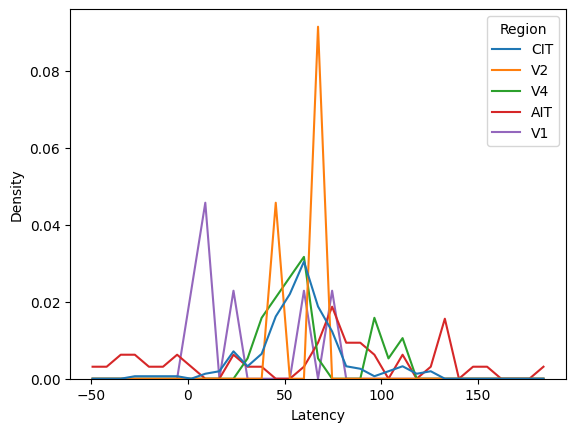

In [12]:
print('Array-level latencies, per session')
sns.histplot(data=adf, x='Latency', hue='Region', stat='density', element='poly', common_norm=False, fill=False)

Array-level latencies, per session
After selecting for test boots frac


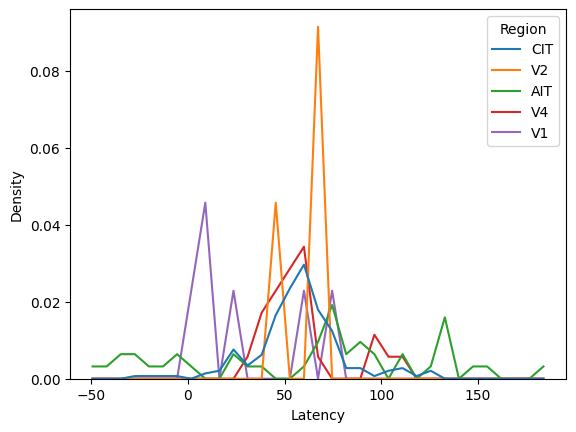

In [13]:
print('Array-level latencies, per session')
print('After selecting for test boots frac')
# note here and below, we select based on test boots frac because
# 1) array-level results are never reported but used as default parameters
# 2) as default parameters, the values should be reliable
adf = adf[adf['Boots. stdev.'] < boots_spread]  # select once
sns.histplot(data=adf, x='Latency', hue='Region', stat='density', element='poly', common_norm=False, fill=False);

Array-level latencies, median across sessions


Latency Region  Selected  Boots. stdev.
Subject Name                                            
An      1      60.476189     V1       1.0      22.525831
Bo      3      66.152351    AIT       1.0      13.491161
Fr      0      65.294121    CIT       1.0      17.228250
        1      41.153847    CIT       1.0      12.877135
        3      52.356323     V4       1.0       4.490707
Lo      0      70.654945    CIT       1.0      14.083001
        1      56.513935    CIT       1.0      14.242735
        2      65.113632    CIT       1.0      11.099431
Na      0      65.235291     V2       1.0      20.892794
        1      95.330582     V4       1.0      10.050722
Oc      6      53.726028    AIT       1.0      13.577866
Ot      5       6.274900    CIT       1.0      12.135744
Pa      0      10.033557     V1       1.0      11.336017
        1      58.797470    CIT       1.0       3.889773
        2      51.676136    CIT       1.0       8.148097
Re      6     118.304008    AIT       1.0      15.077251
Sw      1      -0.859166    CIT       1.0      20.626948
Ve      2     122.000000    AIT       1.0      17.137336
        3     157.000000    AIT       1.0      17.940790
Ye      0     103.679016    CIT       1.0       8.342596
        1      49.237289    CIT       1.0       5.059591

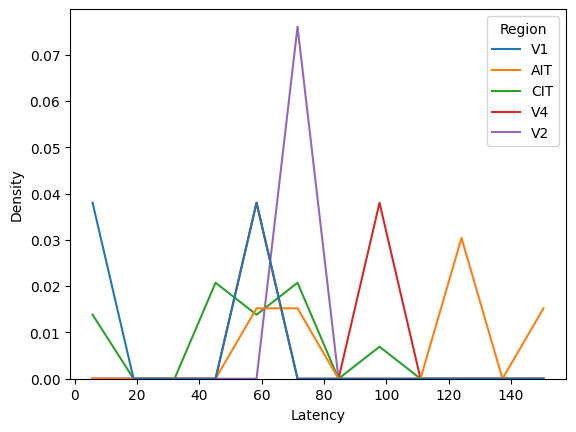

In [14]:
print('Array-level latencies, median across sessions')
df_ = adf.groupby(['Subject', 'Name']).agg({
    'Latency': 'median', 'Region': 'first', 'Selected': 'mean', 'Boots. stdev.': 'median'})
assert df_['Selected'].all()  # sanity check
df_ = df_[df_['Boots. stdev.'] < boots_spread]
sns.histplot(data=df_, x='Latency', hue='Region', stat='density', element='poly', common_norm=False, fill=False);
df_

In [15]:
print('Array-level latencies, median across arrays')
df_.groupby('Region').median()

Array-level latencies, median across arrays


,Latency,Selected,Boots. stdev.
Region,,,
AIT,118.304008,1.0,15.077251
CIT,56.513935,1.0,12.135744
V1,35.254871,1.0,16.930924
V2,65.235291,1.0,20.892794
V4,73.843452,1.0,7.270715


In [16]:
# save array-level resuilts median across sessions
gb = adf.groupby(['Subject', 'Name'])
df_ = gb[cols_to_save].median()
df_['Count'] = gb['Latency'].count()
df_['Region'] = gb['Region'].first()
df_['Level'] = 'Array'
df_ = df_[df_['Boots. stdev.'] < boots_spread]  # select twice
df_ = df_.reset_index().set_index(['Subject', 'Level', 'Name'])
df_.to_csv(f'summary/{analysis_name}_latency{res_tag}{output_sfx}-array_level.csv.gz')
df_

Latency  Boots. stdev.   Clearance  T step   
Subject Level Name                                                  
An      Array 1      60.476189      22.525831  234.235962    10.0  \
Bo      Array 3      66.152351      13.491161  328.761780    10.0   
Fr      Array 0      65.294121      17.228250  281.115387    10.0   
              1      41.153847      12.877135  390.598297    10.0   
              3      52.356323       4.490707  307.692322    10.0   
Lo      Array 0      70.654945      14.083001  284.088470    10.0   
              1      56.513935      14.242735  277.022003    10.0   
              2      65.113632      11.099431  279.518433    10.0   
Na      Array 0      65.235291      20.892794  219.163864    10.0   
              1      95.330582      10.050722  253.627457    10.0   
Oc      Array 6      53.726028      13.577866  311.273987    10.0   
Ot      Array 5       6.274900      12.135744  175.573959    10.0   
Pa      Array 0      10.033557      11.336017  190.844452    10.0   
              1      58.797470       3.889773  301.104980    10.0   
              2      51.676136       8.148097  307.069275    10.0   
Re      Array 6     118.304008      15.077251  243.115448    10.0   
Sw      Array 1      -0.859166      20.626948  251.769623    10.0   
Ve      Array 2     122.000000      17.137336  229.444443    10.0   
              3     157.000000      17.940790  208.000000    10.0   
Ye      Array 0     103.679016       8.342596  318.614258    10.0   
              1      49.237289       5.059591  315.762726    10.0   

                    Boots. frac.  Peak 0 SC  Peak 0 time  Peak 1 SC   
Subject Level Name                                                    
An      Array 1              1.0   0.200195        -45.0   0.144531  \
Bo      Array 3              1.0   0.383789        -70.0   0.526855   
Fr      Array 0              1.0   0.221680        -85.0   0.208008   
              1              1.0   0.194336        -35.0   0.310547   
              3              1.0   0.289062        -15.0   0.365234   
Lo      Array 0              1.0   0.342773        -55.0   0.460449   
              1              1.0   0.258789        -80.0   0.390625   
              2              1.0   0.139648        -35.0   0.219238   
Na      Array 0              1.0   0.223633        -95.0   0.240234   
              1              1.0   0.400391        -25.0   0.268555   
Oc      Array 6              1.0   0.258789        -35.0   0.439453   
Ot      Array 5              1.0   0.419922        -95.0   0.733398   
Pa      Array 0              1.0   0.290039        -85.0   0.249023   
              1              1.0   0.344727        -65.0   0.446289   
              2              1.0   0.256836        -65.0   0.338867   
Re      Array 6              1.0   0.413574        -10.0   0.375488   
Sw      Array 1              1.0   0.240723       -120.0   0.294922   
Ve      Array 2              1.0   0.317871        -75.0   0.166992   
              3              1.0   0.175781        -55.0   0.167969   
Ye      Array 0              1.0   0.145508        -55.0   0.211426   
              1              1.0   0.283203        -95.0   0.433594   

                    Peak 1 time  Count Region  
Subject Level Name                             
An      Array 1           155.0      3     V1  
Bo      Array 3           135.0     24    AIT  
Fr      Array 0           165.0     11    CIT  
              1           155.0      1    CIT  
              3           105.0     17     V4  
Lo      Array 0           125.0     14    CIT  
              1           115.0     20    CIT  
              2           145.0      4    CIT  
Na      Array 0           135.0      3     V2  
              1           155.0      7     V4  
Oc      Array 6           125.0      2    AIT  
Ot      Array 5           165.0      1    CIT  
Pa      Array 0            95.0      3     V1  
              1           115.0     87    CIT  
              2           115.0  